# Predicting the total and electronic dielectric constant from composition features: decreasing variance in datapoints

### Summary:
Dielectric constants are important in designing battery electrolyte. Here, we can try to predict them from composition properties alone  
**The datapoints are modified; X: log(1+X) to decrease variance**

**Methodology:**  
**Dataset:** dielectric_constant from Matminer  
**X_train:** 132 Magpie features, Element Property; log(1+X) modification  
**Model:** Random Forest  
**N:** 1056 (80/20 split)  

**Key Findings:**  
Overfitting still occurs. But better improvement from before  
**Causes:**  
a) ~~Outliers skew the data and the model can't capture them accurately~~  
b) Since there are only ~800 datapoints, the way we split the train/test set affects the model starkly (random_state variable)  
c) The regression model is too complex for just ~800 training datapoints  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pymatgen.core import Composition

import warnings
warnings.filterwarnings('ignore')

rs = 82 #random_state variable

In [2]:
# Load dataset
df = load_dataset('dielectric_constant')
df.head()


,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


In [3]:
# Featurize composition
ep = ElementProperty.from_preset(preset_name="magpie")
df['composition'] = df['formula'].apply(Composition)
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar,composition
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...,"(Rb, Te)"
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...,"(Cd, Cl)"
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...,"(Mn, I)"
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...,"(La, N)"
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...,"(Mn, F)"


In [4]:
df['e_total_scalar'] = df['e_total'].apply(lambda x: np.trace(np.array(ast.literal_eval(x))) / 3 if isinstance(x, str) else np.nan)
df['e_electronic_scalar'] = df['e_electronic'].apply(lambda x: np.trace(np.array(ast.literal_eval(x))) / 3 if isinstance(x, str) else np.nan)
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar,composition,e_total_scalar,e_electronic_scalar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...,"(Rb, Te)",6.234922,3.441253
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...,"(Cd, Cl)",6.726629,3.156762
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...,"(Mn, I)",10.642403,4.974772
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...,"(La, N)",17.992909,7.036249
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...,"(Mn, F)",7.118792,2.352712


In [5]:
df = ep.featurize_dataframe(df, "composition", ignore_errors=True)
X = df[ep.feature_labels()]
y = df[['e_total_scalar', 'e_electronic_scalar']]
#X.to_pickle('X.pkl')
#y.to_pickle('y.pkl')

ElementProperty:   0%|          | 0/1056 [00:00<?, ?it/s]

In [6]:
X.head()
#X.shape

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,37.0,52.0,15.0,42.000000,6.666667,37.0,4.0,90.0,86.0,32.666667,...,0.00000,0.000000,0.000000,0.0,152.0,229.0,77.0,203.333333,34.222222,229.0
1,17.0,48.0,31.0,27.333333,13.777778,17.0,70.0,94.0,24.0,86.000000,...,0.00000,0.000000,0.000000,0.0,64.0,194.0,130.0,107.333333,57.777778,64.0
2,25.0,53.0,28.0,43.666667,12.444444,53.0,52.0,96.0,44.0,81.333333,...,0.00031,0.000103,0.000138,0.0,64.0,217.0,153.0,115.000000,68.000000,64.0
3,7.0,57.0,50.0,32.000000,25.000000,7.0,13.0,82.0,69.0,47.500000,...,0.00000,0.000000,0.000000,0.0,194.0,194.0,0.0,194.000000,0.000000,194.0
4,9.0,25.0,16.0,14.333333,7.111111,9.0,52.0,93.0,41.0,79.333333,...,0.00031,0.000103,0.000138,0.0,15.0,217.0,202.0,82.333333,89.777778,15.0


In [7]:
#X = pd.read_pickle('X.pkl')
#y = pd.read_pickle('y.pkl')
#X.shape()
#y.shape()
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train multi-output regressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=rs))
model.fit(X_train, y_train_log)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=82))

In [8]:
# Predict and evaluate

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_train_pred_log = model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred[:, 0])
test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred[:, 0])
train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred[:, 1])
test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred[:, 1])

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
df_metrics_total

,Train,Test
RMSE total,7.396,27.462
R$^2$ total,0.784,0.129
RMSE elec,5.859,17.510
R$^2$ elec,0.722,0.138


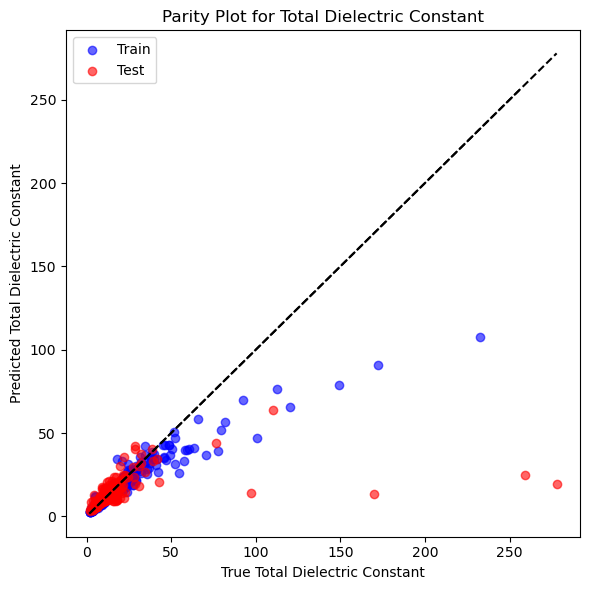

In [9]:
# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_train['e_total_scalar'], y_train_pred[:, 0], alpha=0.6, color='b', marker='o', label='Train')
plt.scatter(y_test['e_total_scalar'], y_pred[:, 0], alpha=0.6, color='r', marker='o', label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel("True Total Dielectric Constant")
plt.ylabel("Predicted Total Dielectric Constant")
plt.title("Parity Plot for Total Dielectric Constant")
plt.legend()
plt.tight_layout()
plt.show()

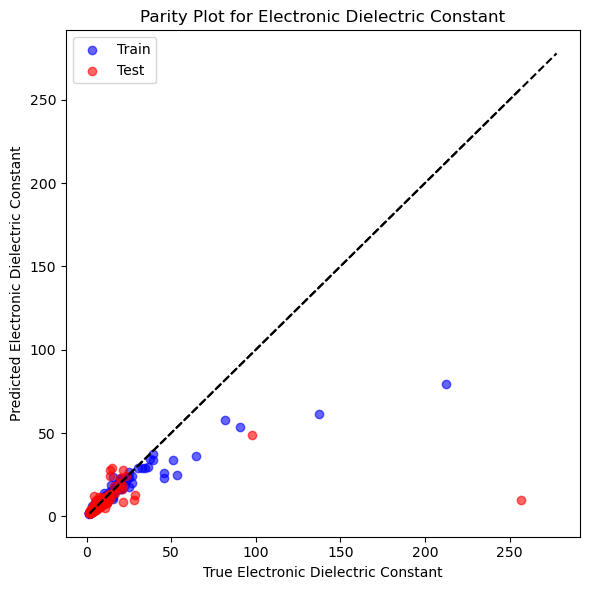

In [10]:
# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_train['e_electronic_scalar'], y_train_pred[:, 1], alpha=0.6, color='b', marker='o', label='Train')
plt.scatter(y_test['e_electronic_scalar'], y_pred[:, 1], alpha=0.6, color='r', marker='o', label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel("True Electronic Dielectric Constant")
plt.ylabel("Predicted Electronic Dielectric Constant")
plt.title("Parity Plot for Electronic Dielectric Constant")
plt.legend()
plt.tight_layout()
plt.show()